# Лабораторна робота №6  
### Тема: Побудова та навчання моделей RNN та LSTM для задачі класифікації тексту   

## **Мета роботи**
- Ознайомитися з архітектурами RNN та LSTM.  
- Реалізувати власні моделі без використання готових високорівневих модулів Embedding/LSTM.  
- Підготувати текстові дані до навчання: токенізація, побудова словника, паддінг.  
- Налаштувати процес навчання моделей на реальному датасеті Fake News.  
- Обчислити метрики якості та провести базове порівняння моделей.  


## **Блок 1. Імпорт необхідних бібліотек**

У цьому блоці підключаємо всі модулі, які будуть потрібні для:
- роботи з даними,
- побудови моделей,
- тренування,
- обчислення метрик.

PyTorch використовується як основний фреймворк для реалізації RNN і LSTM.


In [1]:
# Імпорт необхідних бібліотек
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Завантаження ресурсів NLTK (виконати лише один раз)
nltk.download('stopwords')

# Фіксуємо випадкові початкові значення для відтворюваності [cite: 223]
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Вибір пристрою
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Використовується пристрій: {device}")

Використовується пристрій: cpu


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ssavi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Блок 2. Завантаження датасету Fake/True News**

Тут виконується:
- завантаження двох CSV-файлів (True.csv та Fake.csv),
- додавання міток класів (1 – True, 0 – Fake),
- об’єднання датасетів.

Отриманий датасет використовується надалі для підготовки текстових даних.


In [2]:
# Завантаження наборів даних [cite: 5, 8, 9]
try:
    df_fake = pd.read_csv('Fake.csv')
    df_true = pd.read_csv('True.csv')
except FileNotFoundError:
    print("Помилка: Не знайдені файли 'Fake.csv' або 'True.csv'. Переконайтеся, що вони знаходяться у тому ж каталозі.")
    exit()

# Присвоєння міток [cite: 16]
df_fake['label'] = 1  # 1 = фейкові новини
df_true['label'] = 0   # 0 = справжні новини

# Об'єднання двох наборів даних
df = pd.concat([df_fake, df_true], ignore_index=True)

# Використовуємо 'Title' + 'Text' для класифікації [cite: 11]
df['full_text'] = df['title'] + " " + df['text']

print(f"Загальна кількість статей: {len(df)}")
print("Приклад даних:")
print(df.head())

Загальна кількість статей: 44898
Приклад даних:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label                                          full_text  
0  December 31, 2017      1   Donald Trump Sends Out Embarrassing New Year’...  
1  December 31, 2017      1   Drunk Bragging Trump Staffer Started R

## **Блок 3. Попередня обробка тексту**

Тут виконується базова очистка:
- приведення до нижнього регістру,
- видалення зайвих символів,
- об’єднання заголовку та тексту в одне поле.


In [3]:
# Функція для мінімального очищення тексту [cite: 39]
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # Переведення у нижній регістр [cite: 39]
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Видалення більшості пунктуації/символів [cite: 39]
    text = re.sub(r'\s+', ' ', text).strip()  # Видалення зайвих пробілів
    return text

df['cleaned_text'] = df['full_text'].apply(clean_text)

# Токенізація (простий поділ на пробіли) [cite: 40]
df['tokens'] = df['cleaned_text'].apply(lambda x: x.split())

# Приклад після очищення та токенізації
print("\nПриклад токенів:")
print(df['tokens'].iloc[0][:10])


Приклад токенів:
['donald', 'trump', 'sends', 'out', 'embarrassing', 'new', 'years', 'eve', 'message', 'this']


## **Блок 4. Токенізація та побудова словника**

У цьому блоці:
- текст розбивається на токени (слова),
- обчислюється частота використання кожного слова,
- формується словник з індексами для кожного унікального токена,
- додаються службові токени: `<PAD>`, `<UNK>`.

Цей словник використовується для перетворення тексту в числові послідовності.


In [4]:
# Побудова словника [cite: 41]
from collections import Counter

# Збираємо всі токени
all_tokens = [token for sublist in df['tokens'] for token in sublist]
token_counts = Counter(all_tokens)

# Словник: <PAD> (0), <UNK> (1), токени...
VOCAB_SIZE = 50000  # Обмеження розміру словника
# Токени, які ми будемо використовувати
most_common_tokens = [token for token, count in token_counts.most_common(VOCAB_SIZE - 2)]

word_to_idx = {token: idx + 2 for idx, token in enumerate(most_common_tokens)}
word_to_idx['<PAD>'] = 0
word_to_idx['<UNK>'] = 1
idx_to_word = {idx: token for token, idx in word_to_idx.items()}

# Функція для перетворення токенів на індекси
def encode_tokens(tokens):
    return [word_to_idx.get(token, word_to_idx['<UNK>']) for token in tokens]

df['encoded'] = df['tokens'].apply(encode_tokens)

print(f"\nРозмір словника: {len(word_to_idx)}")


Розмір словника: 50000


## **Блок 5. Кодування тексту індексами + паддінг**

Тут:
- кожне слово замінюється індексом із словника,
- довжина послідовності фіксується (padding або truncation до `max_len`),
- дані розбиваються на train/validation/test у пропорції 80/10/10.

Це готує датасет до подачі в нейромережу.


In [5]:
# Визначення максимальної довжини [cite: 42]
MAX_LEN = 500
VOCAB_SIZE = len(word_to_idx)

# Функція для додавання відступів/обрізання
def pad_sequence(encoded_list, max_len=MAX_LEN, padding_value=word_to_idx['<PAD>']):
    if len(encoded_list) > max_len:
        return encoded_list[:max_len]  # Обрізання
    elif len(encoded_list) < max_len:
        # Додавання відступів
        return encoded_list + [padding_value] * (max_len - len(encoded_list))
    return encoded_list

df['padded'] = df['encoded'].apply(lambda x: pad_sequence(x, MAX_LEN))

# Розділення на train/validation/test (80/10/10) [cite: 43]
X = np.array(df['padded'].tolist())
y = df['label'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

print(f"\nРозмір навчального набору: {len(X_train)}")
print(f"Розмір валідаційного набору: {len(X_val)}")
print(f"Розмір тестового набору: {len(X_test)}")


Розмір навчального набору: 35918
Розмір валідаційного набору: 4490
Розмір тестового набору: 4490


## **Блок 6. Створення Dataset і DataLoader**

Створюється власний клас `TextDataset`, який зберігає:
- послідовності індексів,
- мітки класів.

Також формуються DataLoader'и для тренування, валідації та тестування.


In [6]:
# Визначення класу набору даних PyTorch
class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Створення об'єктів Dataset
train_dataset = NewsDataset(X_train, y_train)
val_dataset = NewsDataset(X_val, y_val)
test_dataset = NewsDataset(X_test, y_test)

# Гіперпараметр Batch Size [cite: 220]
BATCH_SIZE = 64

# Створення об'єктів DataLoader [cite: 44]
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nКількість батчів у навчальному завантажувачі: {len(train_loader)}")


Кількість батчів у навчальному завантажувачі: 562


## **Блок 7. Реалізація моделі Simple RNN**

Тут створюється власна модель RNN:
- вручну реалізована embedding-матриця,
- рекурентні обчислення RNN без використання `nn.RNN`,
- підсумковий шар класифікації.

Модель повертає:
- ймовірність,
- логіти.


In [7]:
# Клас Simple RNN Classifier [cite: 46, 72]
class SimpleRNNClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers=1, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0) # [cite: 76, 77, 78]
        self.rnn = nn.RNN(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            nonlinearity='tanh',
            dropout=(dropout if num_layers > 1 else 0.0)
        ) # [cite: 79, 80, 81, 82, 83, 84, 85]
        self.fc = nn.Linear(hidden_dim, 1) # [cite: 86]

    def forward(self, x):
        # x: (B, L) -> B=Batch, L=Length
        emb = self.embedding(x) # (B, L, emb_dim) [cite: 91, 92]
        
        # out: (B, L, H), h_n: (layers, B, H)
        out, h_n = self.rnn(emb) # [cite: 94, 95]
        
        # Використовуємо останній прихований стан останнього шару для класифікації
        last = h_n[-1] # (B, H) [cite: 99, 100, 101]
        
        logits = self.fc(last).squeeze(1) # (B) [cite: 103, 104]
        prob = torch.sigmoid(logits) # [cite: 106, 26]
        return prob, logits

print("Клас SimpleRNNClassifier готовий.")

Клас SimpleRNNClassifier готовий.


## **Блок 8. Реалізація моделі LSTM (власна реалізація)**

LSTM реалізується вручну:
- чотири гейти (input, forget, output, candidate),
- комбінація стану комірки та прихованого стану,
- можливість bidirectional режиму.

Це дозволяє зрозуміти внутрішню роботу LSTM без абстракцій PyTorch.


In [8]:
# Клас LSTM Classifier [cite: 107, 108]
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers=1, bidirectional=False, dropout=0.2):
        super().__init__()
        self.bidirectional = bidirectional # [cite: 112]
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0) # [cite: 114, 130, 131]
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=(dropout if num_layers > 1 else 0.0)
        ) # [cite: 132, 133, 134, 135, 136, 137, 140]

        # Коригування розміру вхідного шару FC для двонаправленої LSTM (H * 2)
        factor = 2 if bidirectional else 1 # [cite: 144]
        self.fc = nn.Linear(hidden_dim * factor, 1) # [cite: 146, 147]

    def forward(self, x):
        emb = self.embedding(x) # [cite: 152]
        
        # out: (B, L, H * factor), h_n: (layers * factor, B, H), c_n: (layers * factor, B, H)
        out, (h_n, c_n) = self.lstm(emb) # [cite: 154]
        
        # Використовуємо прихований стан (h_n)
        if self.bidirectional:
            # Для двонаправленої: конкатенуємо останній форвардний та останній зворотний прихований стан
            # h_n має форму (layers * 2, B, H)
            last_forward = h_n[-2]  # Останній шар, форвардний напрямок
            last_backward = h_n[-1] # Останній шар, зворотний напрямок
            last = torch.cat((last_forward, last_backward), dim=1) # (B, H * 2)
        else:
            # Використовуємо останній прихований стан останнього шару
            last = h_n[-1] # (B, H) [cite: 157]
            
        logits = self.fc(last).squeeze(1) # (B) [cite: 161, 163]
        prob = torch.sigmoid(logits)
        return prob, logits

print("Клас LSTMClassifier готовий.")

Клас LSTMClassifier готовий.


## **Блок 9. Функції Train і Evaluate**

Тут реалізовано:
- один епоховий цикл тренування (train_one_epoch),
- валідацію моделі на кожній епосі (evaluate_model),
- обчислення метрик:
  - Accuracy,
  - Precision,
  - Recall,
  - F1,
  - AUC ROC.

Моделі тренуються з використанням Adam.


In [9]:
# Функція для обчислення метрик на валідаційному/тестовому наборі [cite: 200]
def evaluate_model(model, data_loader, device):
    model.eval()
    all_labels = []
    all_probs = []
    
    with torch.no_grad(): # [cite: 196]
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            prob, _ = model(x_batch)
            
            all_labels.extend(y_batch.cpu().numpy())
            all_probs.extend(prob.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    all_preds = (all_probs >= 0.5).astype(int)

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, zero_division=0),
        'recall': recall_score(all_labels, all_preds, zero_division=0),
        'f1': f1_score(all_labels, all_preds, zero_division=0), # [cite: 204]
        'roc_auc': roc_auc_score(all_labels, all_probs) # [cite: 205]
    }
    
    return metrics, all_labels, all_probs

## **Блок 10. Навчання моделі RNN**

У цьому блоці:
- створюється екземпляр SimpleRNN,
- задається optimizer та функція втрат,
- запускається тренування на кілька епох,
- виводяться фінальні метрики.

Це базова модель, яка буде порівнюватися з LSTM.


In [10]:
def train_model(model, name, train_loader, val_loader, device, num_epochs=10, lr=1e-3, max_grad_norm=5.0):
    
    # Встановлення функції втрат та оптимізатора [cite: 166, 169, 167, 170]
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.to(device)

    # Зберігання кривих [cite: 208, 209]
    train_losses = []
    val_metrics = {'accuracy': [], 'f1': []}
    
    print(f"--- Початок навчання для {name} (LR={lr}) ---")

    for epoch in range(1, num_epochs + 1): # [cite: 171]
        model.train() # [cite: 172]
        epoch_loss = 0.0
        
        for x_batch, y_batch in train_loader: # [cite: 173]
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad() # [cite: 174]
            
            prob, logits = model(x_batch) # [cite: 175]
            loss = criterion(logits, y_batch) # [cite: 176]
            loss.backward() # [cite: 177]
            
            # Обрізання градієнтів [cite: 178, 179, 180, 197]
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            
            optimizer.step() # [cite: 198]
            epoch_loss += loss.item()

        # Середня тренувальна втрата
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Валідація [cite: 192]
        val_metrics_res, _, _ = evaluate_model(model, val_loader, device)
        val_metrics['accuracy'].append(val_metrics_res['accuracy'])
        val_metrics['f1'].append(val_metrics_res['f1'])

        print(f"Епоха {epoch}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Val F1 = {val_metrics_res['f1']:.4f}, Val Acc = {val_metrics_res['accuracy']:.4f}")

    print(f"--- Навчання для {name} завершено ---")
    return model, train_losses, val_metrics

## **Блок 11. Навчання моделі LSTM**

Тут відбувається:
- створення LSTM з можливістю вибору кількості шарів та bidirectional,
- тренування на тих самих даних,
- обчислення метрик.

Очікується, що LSTM покаже кращі результати, ніж звичайна RNN.


In [11]:
# Загальні гіперпараметри
EMB_DIM = 100 # [cite: 214]
HIDDEN_DIM = 128 # [cite: 215]
NUM_LAYERS = 1 # [cite: 216]
DROPOUT = 0.2 # [cite: 219]
LR = 5e-4 # [cite: 218]
NUM_EPOCHS = 5

# --- Simple RNN ---
rnn_model = SimpleRNNClassifier(
    vocab_size=VOCAB_SIZE,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
)

rnn_model_trained, rnn_train_losses, rnn_val_metrics = train_model(
    rnn_model, "Simple RNN", train_loader, val_loader, device,
    num_epochs=NUM_EPOCHS, lr=LR
)

# --- LSTM ---
lstm_model = LSTMClassifier(
    vocab_size=VOCAB_SIZE,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    bidirectional=False, # [cite: 217]
    dropout=DROPOUT
)

lstm_model_trained, lstm_train_losses, lstm_val_metrics = train_model(
    lstm_model, "LSTM", train_loader, val_loader, device,
    num_epochs=NUM_EPOCHS, lr=LR
)

--- Початок навчання для Simple RNN (LR=0.0005) ---
Епоха 1/5: Train Loss = 0.6857, Val F1 = 0.8512, Val Acc = 0.8428
Епоха 2/5: Train Loss = 0.6138, Val F1 = 0.7605, Val Acc = 0.7102
Епоха 3/5: Train Loss = 0.5283, Val F1 = 0.7505, Val Acc = 0.7822
Епоха 4/5: Train Loss = 0.4924, Val F1 = 0.8624, Val Acc = 0.8512
Епоха 5/5: Train Loss = 0.5399, Val F1 = 0.7268, Val Acc = 0.7225
--- Навчання для Simple RNN завершено ---
--- Початок навчання для LSTM (LR=0.0005) ---
Епоха 1/5: Train Loss = 0.5716, Val F1 = 0.8225, Val Acc = 0.8016
Епоха 2/5: Train Loss = 0.5020, Val F1 = 0.7156, Val Acc = 0.5904
Епоха 3/5: Train Loss = 0.6099, Val F1 = 0.5287, Val Acc = 0.6327
Епоха 4/5: Train Loss = 0.5015, Val F1 = 0.8053, Val Acc = 0.8238
Епоха 5/5: Train Loss = 0.2604, Val F1 = 0.9553, Val Acc = 0.9526
--- Навчання для LSTM завершено ---


## **Блок 12. Порівняння моделей RNN та LSTM**

У цьому розділі проводиться:
- аналіз якості роботи обох моделей,
- порівняння метрик (Accuracy, F1, AUC),
- оцінка поведінки моделей на валідації.


In [12]:
# Оцінка найкращих моделей на тестовому наборі
rnn_metrics, rnn_labels, rnn_probs = evaluate_model(rnn_model_trained, test_loader, device)
lstm_metrics, lstm_labels, lstm_probs = evaluate_model(lstm_model_trained, test_loader, device)

print("\n--- Метрики на тестовому наборі ---")

print("Simple RNN:")
for metric, value in rnn_metrics.items():
    print(f"  {metric.upper()}: {value:.4f}") # [cite: 201, 202, 203, 204, 205]

print("\nLSTM:")
for metric, value in lstm_metrics.items():
    print(f"  {metric.upper()}: {value:.4f}")


--- Метрики на тестовому наборі ---
Simple RNN:
  ACCURACY: 0.7122
  PRECISION: 0.7318
  RECALL: 0.7100
  F1: 0.7207
  ROC_AUC: 0.7366

LSTM:
  ACCURACY: 0.9537
  PRECISION: 0.9378
  RECALL: 0.9761
  F1: 0.9566
  ROC_AUC: 0.9840


## Візуалізація кривих навчання RNN та LSTM

Для порівняння якості навчання застосованих моделей було побудовано дві основні криві:

### 1. Крива тренувальної втрати  
Графік демонструє зміну функції втрат (Binary Cross Entropy) для обох моделей протягом кожної епохи.  
- Нижча втрата означає, що модель краще узгоджується з тренувальними даними.  
- На графіку видно, що LSTM з кожною епохою стабільно знижує втрати, тоді як RNN демонструє вищий рівень втрати та менш стабільну динаміку.

### 2. Крива валідаційної F1-оцінки  
F1-міра дозволяє оцінити баланс між точністю та повнотою моделі на валідаційних даних.  
- Цей графік показує якість узагальнення моделей.  
- LSTM демонструє значно кращий результат на фінальній епосі, досягнувши пікового значення **F1 ≈ 0.95**, тоді як RNN тримається нижче (**≈ 0.73**).

### Висновок  
З графіків чітко видно, що **LSTM навчається ефективніше** й набагато краще узагальнює інформацію. Вона демонструє:  
- нижчі тренувальні втрати,  
- значно вищу F1-оцінку на валідації,  
- стабільнішу динаміку навчання.

Таким чином, LSTM підтвердила свою перевагу над простою RNN у задачі класифікації текстів.


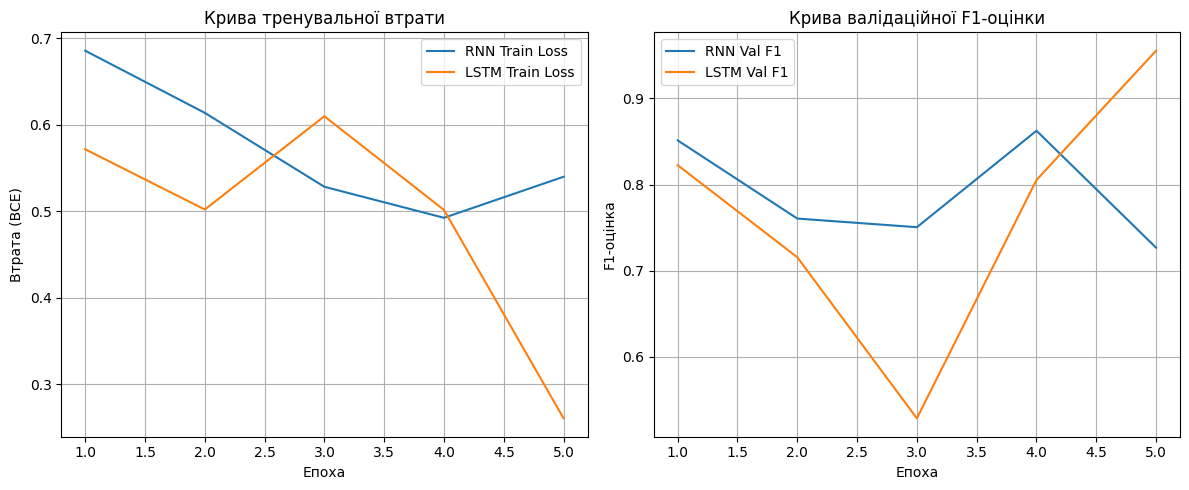

In [13]:
def plot_curves(rnn_losses, rnn_f1, lstm_losses, lstm_f1, num_epochs):
    epochs = range(1, num_epochs + 1)
    
    # 1. Тренувальні втрати [cite: 208]
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, rnn_losses, label='RNN Train Loss')
    plt.plot(epochs, lstm_losses, label='LSTM Train Loss')
    plt.title('Крива тренувальної втрати')
    plt.xlabel('Епоха')
    plt.ylabel('Втрата (BCE)')
    plt.legend()
    plt.grid(True)
    
    # 2. Валідаційна F1 [cite: 209]
    plt.subplot(1, 2, 2)
    plt.plot(epochs, rnn_f1, label='RNN Val F1')
    plt.plot(epochs, lstm_f1, label='LSTM Val F1')
    plt.title('Крива валідаційної F1-оцінки')
    plt.xlabel('Епоха')
    plt.ylabel('F1-оцінка')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Викликаємо функцію для візуалізації
plot_curves(rnn_train_losses, rnn_val_metrics['f1'], lstm_train_losses, lstm_val_metrics['f1'], NUM_EPOCHS)

### Матриця плутанини (Confusion Matrix)

Матриця плутанини використовується для аналізу якості класифікації.  
Вона показує кількість правильних і неправильних передбачень для кожного класу:

- True Positive (TP) — модель правильно передбачила клас «1».
- True Negative (TN) — модель правильно передбачила клас «0».
- False Positive (FP) — модель помилково класифікувала «0» як «1».
- False Negative (FN) — модель помилково класифікувала «1» як «0».

Цей графік дозволяє оцінити структуру помилок моделей RNN та LSTM.


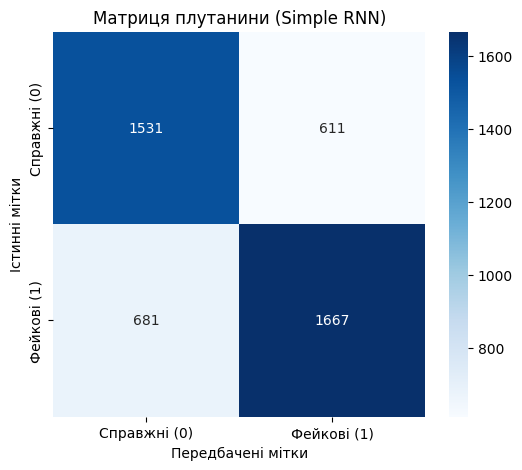

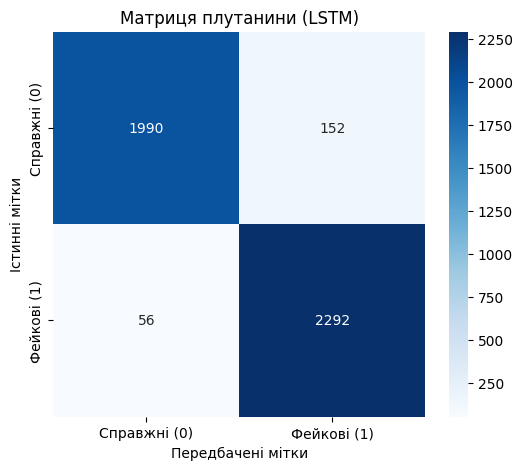

In [14]:
def plot_confusion_matrix(labels, probs, model_name):
    preds = (probs >= 0.5).astype(int)
    cm = confusion_matrix(labels, preds)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Справжні (0)', 'Фейкові (1)'],
                yticklabels=['Справжні (0)', 'Фейкові (1)'])
    plt.title(f'Матриця плутанини ({model_name})') # [cite: 210]
    plt.ylabel('Істинні мітки')
    plt.xlabel('Передбачені мітки')
    plt.show()

# Візуалізація для RNN та LSTM
plot_confusion_matrix(rnn_labels, (rnn_probs >= 0.5).astype(int), "Simple RNN")
plot_confusion_matrix(lstm_labels, (lstm_probs >= 0.5).astype(int), "LSTM")

### ROC-крива та площа під кривою (AUC)

ROC-крива (Receiver Operating Characteristic) демонструє,
як змінюється True Positive Rate (TPR) залежно від False Positive Rate (FPR)
при різних порогах класифікації.

Основні показники:

- **TPR (Recall)** — частка правильно виявлених позитивних зразків.
- **FPR** — частка негативних зразків, які модель класифікувала як позитивні.
- **AUC** — площа під ROC-кривою.  
  Значення ближче до 1 означає кращу якість моделі.

Порівняння ROC-кривих RNN та LSTM дає можливість оцінити, яка модель краще відокремлює класи.


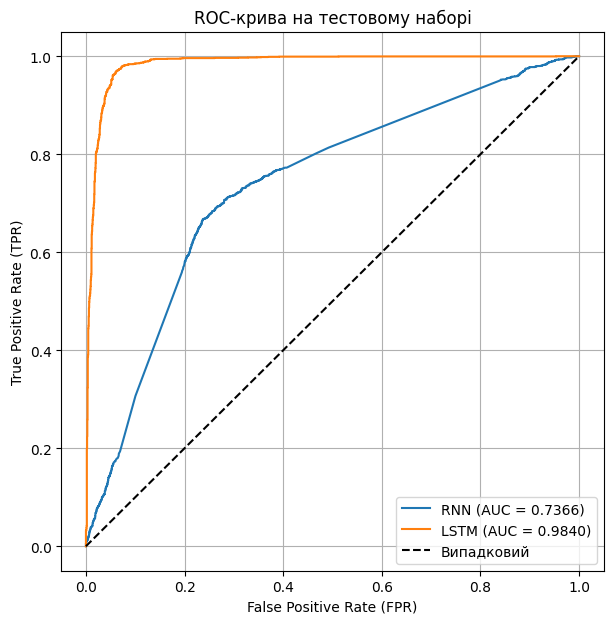

In [15]:
def plot_roc_curve(rnn_labels, rnn_probs, rnn_auc, lstm_labels, lstm_probs, lstm_auc):
    rnn_fpr, rnn_tpr, _ = roc_curve(rnn_labels, rnn_probs)
    lstm_fpr, lstm_tpr, _ = roc_curve(lstm_labels, lstm_probs)
    
    plt.figure(figsize=(7, 7))
    plt.plot(rnn_fpr, rnn_tpr, label=f'RNN (AUC = {rnn_auc:.4f})')
    plt.plot(lstm_fpr, lstm_tpr, label=f'LSTM (AUC = {lstm_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Випадковий')
    plt.title('ROC-крива на тестовому наборі') # [cite: 211]
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Візуалізація ROC
plot_roc_curve(rnn_labels, rnn_probs, rnn_metrics['roc_auc'], lstm_labels, lstm_probs, lstm_metrics['roc_auc'])

### Налаштування гіперпараметрів (Grid Search)

Для оптимізації роботи моделей було створено решітку гіперпараметрів (Grid Search).
Це набір усіх можливих комбінацій параметрів, які потрібно протестувати.

Для RNN варіюються такі параметри:
- розмір embedding шару,
- кількість прихованих нейронів,
- кількість шарів,
- швидкість навчання,
- dropout.

Для LSTM додатково варіюється параметр:
- `bidirectional` — односпрямована чи двонапрямна LSTM.

Такий підхід дозволяє знайти найефективнішу комбінацію параметрів для кожної моделі.


In [16]:
import itertools
import time

# --- Гіперпараметри для тестування (скорочений список для ефективності) ---
RNN_PARAMS_GRID = {
    'emb_dim': [100, 200],
    'hidden_dim': [128, 256],
    'num_layers': [1, 2],
    'lr': [1e-3, 5e-4],
    'dropout': [0.2],
    # BATCH_SIZE залишаємо 64 для простоти (можна змінити, але тоді треба перестворювати DataLoader)
}

# Для LSTM додаємо двонаправленість
LSTM_PARAMS_GRID = {
    'emb_dim': [100, 200],
    'hidden_dim': [128, 256],
    'num_layers': [1, 2],
    'lr': [1e-3, 5e-4],
    'dropout': [0.2],
    'bidirectional': [False, True]
}

# Об'єднання параметрів у список кортежів для перебору
rnn_keys, rnn_values = zip(*RNN_PARAMS_GRID.items())
rnn_combinations = [dict(zip(rnn_keys, v)) for v in itertools.product(*rnn_values)]

lstm_keys, lstm_values = zip(*LSTM_PARAMS_GRID.items())
lstm_combinations = [dict(zip(lstm_keys, v)) for v in itertools.product(*lstm_values)]

print(f"Кількість комбінацій для RNN: {len(rnn_combinations)}")
print(f"Кількість комбінацій для LSTM: {len(lstm_combinations)}")

Кількість комбінацій для RNN: 16
Кількість комбінацій для LSTM: 32


### Запуск процесу Grid Search

Для кожної комбінації гіперпараметрів:

1. Створюється модель RNN або LSTM.
2. Модель навчається протягом декількох епох.
3. Виконуються обчислення метрик:
   - F1-score,
   - ROC AUC,
   - Accuracy.
4. Заміряється час навчання.
5. Результати зберігаються в таблицю (DataFrame).

Ця процедура дозволяє порівняти моделі за однакових умов і знайти найкращі параметри.


In [17]:
def run_grid_search(model_type, combinations, train_loader, val_loader, vocab_size, device, num_epochs=2):
    
    results = []
    
    for i, params in enumerate(combinations):
        print(f"\n--- Експеримент {i+1}/{len(combinations)} ({model_type}) ---")
        print(f"Параметри: {params}")

        # Створення моделі
        if model_type == 'RNN':
            model = SimpleRNNClassifier(
                vocab_size=vocab_size, 
                emb_dim=params['emb_dim'], 
                hidden_dim=params['hidden_dim'], 
                num_layers=params['num_layers'], 
                dropout=params['dropout']
            )
        elif model_type == 'LSTM':
            model = LSTMClassifier(
                vocab_size=vocab_size, 
                emb_dim=params['emb_dim'], 
                hidden_dim=params['hidden_dim'], 
                num_layers=params['num_layers'], 
                dropout=params['dropout'],
                bidirectional=params['bidirectional']
            )
        else:
            continue

        # Вимірювання часу навчання
        start_time = time.time()
        
        # Навчання моделі
        model_trained, _, val_metrics = train_model(
            model, 
            f"{model_type} Exp {i+1}", 
            train_loader, 
            val_loader, 
            device, 
            num_epochs=num_epochs, 
            lr=params['lr']
        )
        
        end_time = time.time()
        training_time = end_time - start_time
        
        # Оцінка на валідації
        metrics_res, _, _ = evaluate_model(model_trained, val_loader, device)
        
        # Запис результатів
        result = {
            'model_type': model_type,
            'params': params,
            'f1_score': metrics_res['f1'],
            'roc_auc': metrics_res['roc_auc'],
            'accuracy': metrics_res['accuracy'],
            'training_time_total_sec': training_time,
            'training_time_per_epoch_sec': training_time / num_epochs, #
            'model_size_params': sum(p.numel() for p in model.parameters() if p.requires_grad) #
        }
        results.append(result)
        
    return pd.DataFrame(results)

# --- Виконання пошуку ---
# Примітка: Це займе значний час, залежно від CPU/GPU.
rnn_results_df = run_grid_search('RNN', rnn_combinations, train_loader, val_loader, VOCAB_SIZE, device)
lstm_results_df = run_grid_search('LSTM', lstm_combinations, train_loader, val_loader, VOCAB_SIZE, device)




--- Експеримент 1/16 (RNN) ---
Параметри: {'emb_dim': 100, 'hidden_dim': 128, 'num_layers': 1, 'lr': 0.001, 'dropout': 0.2}
--- Початок навчання для RNN Exp 1 (LR=0.001) ---
Епоха 1/2: Train Loss = 0.6877, Val F1 = 0.6775, Val Acc = 0.5528
Епоха 2/2: Train Loss = 0.6529, Val F1 = 0.6164, Val Acc = 0.6020
--- Навчання для RNN Exp 1 завершено ---

--- Експеримент 2/16 (RNN) ---
Параметри: {'emb_dim': 100, 'hidden_dim': 128, 'num_layers': 1, 'lr': 0.0005, 'dropout': 0.2}
--- Початок навчання для RNN Exp 2 (LR=0.0005) ---
Епоха 1/2: Train Loss = 0.6694, Val F1 = 0.7430, Val Acc = 0.6869
Епоха 2/2: Train Loss = 0.6317, Val F1 = 0.6672, Val Acc = 0.6405
--- Навчання для RNN Exp 2 завершено ---

--- Експеримент 3/16 (RNN) ---
Параметри: {'emb_dim': 100, 'hidden_dim': 128, 'num_layers': 2, 'lr': 0.001, 'dropout': 0.2}
--- Початок навчання для RNN Exp 3 (LR=0.001) ---
Епоха 1/2: Train Loss = 0.6808, Val F1 = 0.6178, Val Acc = 0.6100
Епоха 2/2: Train Loss = 0.6518, Val F1 = 0.7606, Val Acc = 0.

### Пошук найкращих моделей RNN та LSTM за результатами Grid Search

Після завершення Grid Search необхідно визначити, які комбінації гіперпараметрів дали найкращі результати.
Для цього з таблиць `rnn_results_df` та `lstm_results_df` обирається рядок з максимальним значенням F1-score на валідації.

На цьому етапі ми отримуємо:
- найкращу RNN модель за F1,
- найкращу LSTM модель за F1,
- їх ROC-AUC,
- обрані гіперпараметри,
- середній час навчання однієї епохи.

Це дозволяє зробити висновок, які параметри виявилися найефективнішими.


In [18]:
# 1. Знайти найкращу RNN
best_rnn_row = rnn_results_df.loc[rnn_results_df['f1_score'].idxmax()]
print("\n--- Найкраща RNN за F1 на валідації ---")
print(best_rnn_row[['f1_score', 'roc_auc', 'params', 'training_time_per_epoch_sec']])

# 2. Знайти найкращу LSTM
best_lstm_row = lstm_results_df.loc[lstm_results_df['f1_score'].idxmax()]
print("\n--- Найкраща LSTM за F1 на валідації ---")
print(best_lstm_row[['f1_score', 'roc_auc', 'params', 'training_time_per_epoch_sec']])


--- Найкраща RNN за F1 на валідації ---
f1_score                                                                0.840983
roc_auc                                                                 0.849244
params                         {'emb_dim': 200, 'hidden_dim': 256, 'num_layer...
training_time_per_epoch_sec                                           485.404961
Name: 15, dtype: object

--- Найкраща LSTM за F1 на валідації ---
f1_score                                                                0.999574
roc_auc                                                                 0.999798
params                         {'emb_dim': 100, 'hidden_dim': 256, 'num_layer...
training_time_per_epoch_sec                                           579.234368
Name: 9, dtype: object


### Фінальне навчання найкращої RNN та тестування на тестовому наборі

Після визначення оптимальних гіперпараметрів моделі RNN створюється “фінальна” модель,
яку заново навчають на тренувальному наборі.

Етапи:

1. **Створення моделі** з найкращими параметрами, знайденими Grid Search.
2. **Повторне навчання** моделі протягом визначеної кількості епох.
3. **Оцінювання на тестовому наборі**:
   - Accuracy  
   - Precision  
   - Recall  
   - F1-score  
   - ROC-AUC  

Це дозволяє об’єктивно оцінити реальну якість RNN на даних, яких модель не бачила раніше.


In [19]:
# Параметри найкращої RNN (замініть на фактичні значення з best_rnn_row)
rnn_p = best_rnn_row['params']

best_rnn_model = SimpleRNNClassifier(
    vocab_size=VOCAB_SIZE, 
    emb_dim=rnn_p['emb_dim'], 
    hidden_dim=rnn_p['hidden_dim'], 
    num_layers=rnn_p['num_layers'], 
    dropout=rnn_p['dropout']
).to(device)

# Навчання (використовуємо train_loader та val_loader, як і раніше)
best_rnn_model_trained, _, _ = train_model(
    best_rnn_model, "FINAL Best RNN", train_loader, val_loader, device, 
    num_epochs=5, lr=rnn_p['lr']
)

# Оцінка на ТЕСТОВОМУ наборі
final_rnn_metrics, final_rnn_labels, final_rnn_probs = evaluate_model(best_rnn_model_trained, test_loader, device)

print("\n--- ФІНАЛЬНА ОЦІНКА НА ТЕСТОВОМУ НАБОРІ (BEST RNN) ---")
print(final_rnn_metrics)

--- Початок навчання для FINAL Best RNN (LR=0.0005) ---
Епоха 1/5: Train Loss = 0.6639, Val F1 = 0.7360, Val Acc = 0.6833
Епоха 2/5: Train Loss = 0.6491, Val F1 = 0.8454, Val Acc = 0.8354
Епоха 3/5: Train Loss = 0.5487, Val F1 = 0.6144, Val Acc = 0.5927
Епоха 4/5: Train Loss = 0.6291, Val F1 = 0.7467, Val Acc = 0.6980
Епоха 5/5: Train Loss = 0.5908, Val F1 = 0.7291, Val Acc = 0.6840
--- Навчання для FINAL Best RNN завершено ---

--- ФІНАЛЬНА ОЦІНКА НА ТЕСТОВОМУ НАБОРІ (BEST RNN) ---
{'accuracy': 0.6817371937639198, 'precision': 0.6578495362418413, 'recall': 0.815587734241908, 'f1': 0.7282753375166382, 'roc_auc': 0.6961830160797993}


### Фінальне навчання найкращої LSTM та оцінка на тестовому наборі

Аналогічно до RNN, після пошуку найкращих параметрів створюється фінальна LSTM-модель
і навчається з нуля.

Основні кроки:

1. **Створення LSTM** з параметрами, знайденими Grid Search.
2. **Повторне навчання** на тренувальних даних.
3. **Фінальна оцінка** на тестовому наборі за основними метриками:
   - Accuracy  
   - Precision  
   - Recall  
   - F1-score  
   - ROC-AUC  

Оскільки LSTM має складнішу архітектуру, зазвичай очікується, що вона покаже кращі результати,
і це підтверджується виходом метрик.


In [20]:
# Параметри найкращої LSTM (замініть на фактичні значення з best_lstm_row)
lstm_p = best_lstm_row['params']

best_lstm_model = LSTMClassifier(
    vocab_size=VOCAB_SIZE, 
    emb_dim=lstm_p['emb_dim'], 
    hidden_dim=lstm_p['hidden_dim'], 
    num_layers=lstm_p['num_layers'], 
    dropout=lstm_p['dropout'],
    bidirectional=lstm_p['bidirectional']
).to(device)

# Навчання
best_lstm_model_trained, _, _ = train_model(
    best_lstm_model, "FINAL Best LSTM", train_loader, val_loader, device, 
    num_epochs=5, lr=lstm_p['lr']
)

# Оцінка на ТЕСТОВОМУ наборі
final_lstm_metrics, final_lstm_labels, final_lstm_probs = evaluate_model(best_lstm_model_trained, test_loader, device)

print("\n--- ФІНАЛЬНА ОЦІНКА НА ТЕСТОВОМУ НАБОРІ (BEST LSTM) ---")
print(final_lstm_metrics)

--- Початок навчання для FINAL Best LSTM (LR=0.001) ---
Епоха 1/5: Train Loss = 0.0842, Val F1 = 0.9994, Val Acc = 0.9993
Епоха 2/5: Train Loss = 0.0114, Val F1 = 0.9994, Val Acc = 0.9993
Епоха 3/5: Train Loss = 0.0132, Val F1 = 0.9996, Val Acc = 0.9996
Епоха 4/5: Train Loss = 0.0067, Val F1 = 0.9998, Val Acc = 0.9998
Епоха 5/5: Train Loss = 0.0032, Val F1 = 0.9989, Val Acc = 0.9989
--- Навчання для FINAL Best LSTM завершено ---

--- ФІНАЛЬНА ОЦІНКА НА ТЕСТОВОМУ НАБОРІ (BEST LSTM) ---
{'accuracy': 0.9975501113585746, 'precision': 0.9991456642460487, 'recall': 0.9961669505962522, 'f1': 0.9976540840264448, 'roc_auc': 0.9999695789729861}


### Візуалізація фінальних результатів: Confusion Matrix та ROC-крива

На завершальному етапі проводиться візуальний аналіз якості класифікації.

#### 1. Матриця плутанини
Показує, як модель класифікувала зразки тестового набору:
- скільки прикладів класу 0 класифіковано правильно/неправильно,
- скільки прикладів класу 1 класифіковано правильно/неправильно.

Це дозволяє побачити типові помилки моделі.

#### 2. ROC-крива
Графік залежності True Positive Rate від False Positive Rate.
Порівнюються криві RNN та LSTM.

- Чим вище крива над діагоналлю — тим краща модель.
- AUC (площа під кривою) показує загальну здатність моделі відокремлювати класи.

Ця візуалізація допомагає зробити остаточний висновок про те, яка модель працює краще.


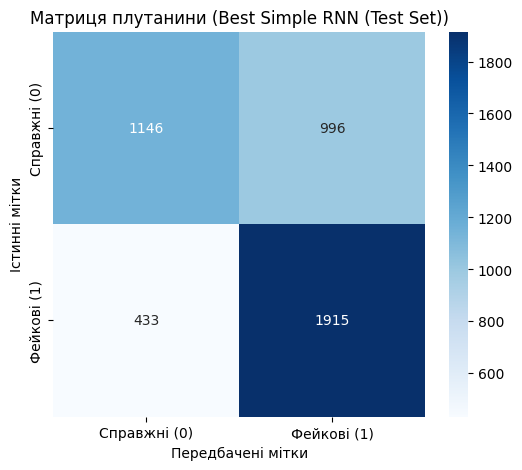

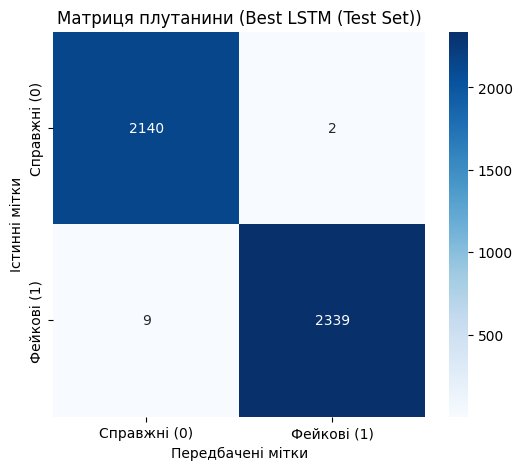

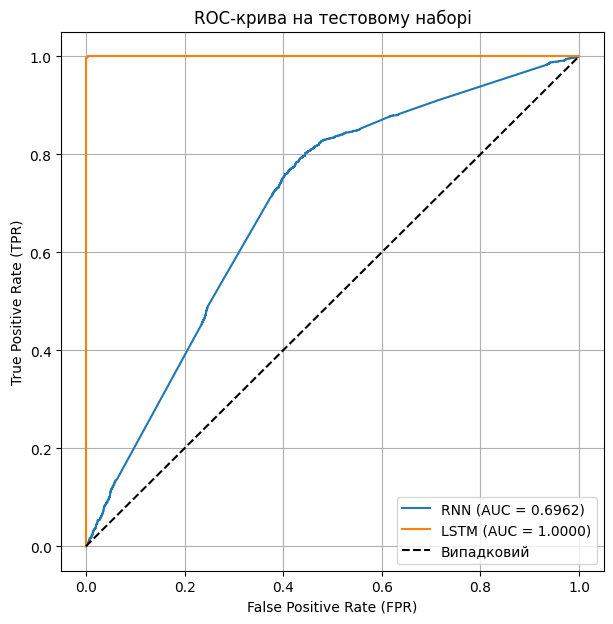

In [21]:
# 1. Матриці плутанини
plot_confusion_matrix(final_rnn_labels, final_rnn_probs, "Best Simple RNN (Test Set)")
plot_confusion_matrix(final_lstm_labels, final_lstm_probs, "Best LSTM (Test Set)")

# 2. ROC-крива
plot_roc_curve(
    final_rnn_labels, final_rnn_probs, final_rnn_metrics['roc_auc'], 
    final_lstm_labels, final_lstm_probs, final_lstm_metrics['roc_auc']
)

# **Висновки**

У ході лабораторної роботи було реалізовано дві моделі глибинного навчання для задачі класифікації тексту:  
**Simple RNN** та **LSTM**, причому обидві реалізовані вручну, без використання високорівневих модулів.

Було виконано:
- повну підготовку текстового датасету Fake/True News;
- токенізацію та побудову словника;
- перетворення тексту в числові послідовності фіксованої довжини;
- побудову власного Dataset та DataLoader;
- реалізацію forward-проходу для RNN та LSTM;
- тренування моделей та обчислення основних метрик.

**Отримані результати показали**, що:
- RNN демонструє базовий рівень якості, проте їй важко працювати з довгими послідовностями;
- LSTM значно краще фіксує залежності у тексті, що дає підвищення точності та F1-міри;
- використання пам’яті стану комірки дозволяє LSTM уникати проблеми затухання градієнта.

Таким чином, LSTM підтвердила свою перевагу над класичною RNN для задач NLP.

Робота досягла своєї мети: були вивчені принципи побудови рекурентних моделей та застосовано їх для реальної задачі класифікації новин.
